In [53]:
import networkx as nx
from pymongo import MongoClient
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import json
from urllib.parse import urlsplit
from urllib.parse import urlparse
import requests
import http.client
from newspaper import Article

In [54]:
client = MongoClient('mongodb://localhost:27017')
db = client["twitterdb"]
collection = db.wfp_search
df = pd.DataFrame(list(collection.find()))

MongoDB documents containing nested data need to be flattened. Here we extract the urls, hashtags, and mentioned users from entities using json_normalize:

In [55]:
tweets_flat = json_normalize(df['entities'])
entities_data = json_normalize(df['entities'], record_path='urls', meta=['hashtags', 'user_mentions'])

In [56]:
def unshorten_url(url):
    parsed = urlparse(url)

    if parsed.scheme == 'https':
        h = http.client.HTTPSConnection(parsed.netloc)
    else:
        h = http.client.HTTPConnection(parsed.netloc)

    resource = parsed.path
    if parsed.query != "": 
        resource += "?" + parsed.query
    h.request('HEAD', resource )
    response = h.getresponse()
    if response.status//100 == 3 and response.getheader('Location'):
        return unshorten_url(response.getheader('Location')) # changed to process chains of short urls
    else:
        return url

Now we can parse the URL. I'm interested in unique domains, so for convience's sake, I'm placing that in a top level attribute column (are they called rows and columns with NoSQL?)

In [59]:
entities_data['protocol'],entities_data['domain'],entities_data['path'],entities_data['query'],entities_data['fragment'] = zip(*[urlsplit(x) for x in entities_data['expanded_url']])
df['domain'] = entities_data['domain']
long_urls = entities_data['expanded_url']
df['url'] = entities_data['expanded_url']

In [ ]:
#df['url'] = entities_data['expanded_url'].apply(unshorten_url)

Now extracting screen names and the user's default language.

In [60]:
user_flat = json_normalize(df['user'])
df['screen_name'] = user_flat['screen_name']
df['lang'] = user_flat['lang']

In [61]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', utc=True)
df['created_at'] = df['created_at'].dt.tz_convert('UTC')
# df = df[(df['created_at'] > '2018-10-14 23:59:59') & (df['created_at'] <= '2019-10-23 05:00:00')]
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
#df = df[~df['url'].str.contains('sirios|refugiados-africanos|estado-islamico', na=False)].reset_index()
#df = df[~df['text'].str.contains('sírios|refugiados africanos|estado islâmico', na=False)].reset_index()

In [62]:
df_pt = df.loc[df['lang'] == 'pt']
df_es = df.loc[df['lang'] == 'es']
df_fr = df.loc[df['lang'] == 'fr']
df_ru = df.loc[df['lang'] == 'ru']
df_en = df.loc[df['lang'] == 'en']

In [63]:
parsed_urls = pd.DataFrame()
parsed_urls = df['domain'].reset_index(name='url')
unique = parsed_urls.groupby('url')['index'].nunique()
unique.nlargest(25)

url
twitter.com                           1770
slate.com                               64
bit.ly                                  52
world-food-programme.contactrh.com      46
charitymiles.org                        15
goo.gl                                  14
medium.com                              11
www.business-standard.com               11
miles.app.link                          10
www.environewsnigeria.com               10
youtu.be                                 9
responsibledata.io                       8
ssir.org                                 7
www.wfp.org                              7
insight.wfp.org                          6
thewaronyemen.org                        6
tmsnrt.rs                                6
buff.ly                                  5
www.ips.lk                               5
dlvr.it                                  4
ninjajobs.org                            4
ow.ly                                    4
paper.li                                 4
www.job

In [64]:
parsed_urls = pd.DataFrame()
parsed_urls = df['url'].reset_index(name='url')
unique_ful = parsed_urls.groupby('url')['index'].nunique()
unique_ful.nlargest(25)

url
https://twitter.com/LIVEOMBNEWYORK/status/1095519013684293632?s=19                                                                94
https://slate.com/technology/2019/02/palantir-un-world-food-programme-data-humanitarians.html                                     60
https://twitter.com/WFP_Zimbabwe/status/1096038521964503040                                                                       21
https://twitter.com/insydeman/status/1094018301154385921                                                                          16
https://twitter.com/engnroom/status/1093806011746533376                                                                           13
https://twitter.com/databaazi/status/1094225866958229504                                                                          11
https://twitter.com/irinnews/status/1093162407793487875                                                                           11
https://www.business-standard.com/article/economy-policy/orissa-i

In [65]:
hashtag_data = json_normalize(df['entities'], record_path='hashtags', meta=['user_mentions', 'urls'])
hashtags = pd.DataFrame()
hashtags = hashtag_data['text'].reset_index(name='hashtags')
utags = hashtags.groupby('hashtags')['index'].nunique()
utags.nlargest(50)

hashtags
Yemen              370
Venezuela          355
Rukban             234
responsibledata    159
SouthSudan         145
live                95
humanitarian        71
TravelTuesday       64
Rohingya            61
Syria               57
PPP                 51
Palantir            44
aid                 44
Sudan               42
WorldGovSummit      41
Education           40
GlobalGoals         40
India               40
China               39
ZeroHunger          37
childern            34
nutrition           33
Zimbabwe            28
Afghanistan         27
COHAKe              27
WFP                 27
DidYouKnow          26
FACT                26
food                25
FF                  24
Tanzania            24
Madagascar          23
hunger              23
Cuba                22
UN                  21
zerohunger          21
AHORA               20
Hodeidah            20
ShareTheMeal        20
TimorLeste          20
photooftheday       20
9Feb                19
FAO                 19
Me

In [66]:
user_count = pd.DataFrame()
user_count = df['screen_name'].reset_index(name='Screen Name')
user_count = user_count.groupby('Screen Name')['index'].nunique()
user_count.nlargest(50)

Screen Name
LIVEOMBNEWYORK     140
WFP_Careers         42
WFP_UK              26
faineg              26
WFP_Africa          25
ouattara_bps        24
WFP_Europe          23
databaazi           23
cecyfernandes       22
emergencyglobal     18
blanketcrap         17
Isaiah21452669      16
MKouyoumjian        16
WFP_MENA            15
mymedicalmantra     15
EnricaPorcari       14
WFP_SouthSudan      14
WFP_Zimbabwe        14
irinnews            14
mnarbs              14
ziadachkar          14
indevjobs           13
joannavdmerwe       13
marek_roxane        13
oumarouhas          13
rjber15             13
DINAHTONNE18        12
WFP_AsiaPacific     12
collectables66      12
seanmmcdonald       12
tedogolla           12
Adesolive           11
MJhogasundram       11
USAIDFFP            11
WFP_Canada          11
3Naasan             10
Andrewk350          10
BillEaster10        10
NiliMajumder        10
amoros_lark         10
jifsmom             10
mfjhollingworth     10
mountainherder      10

In [67]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
tweets_timeline = df.groupby(by=['hour', 'day_of_week'])['text'].count()

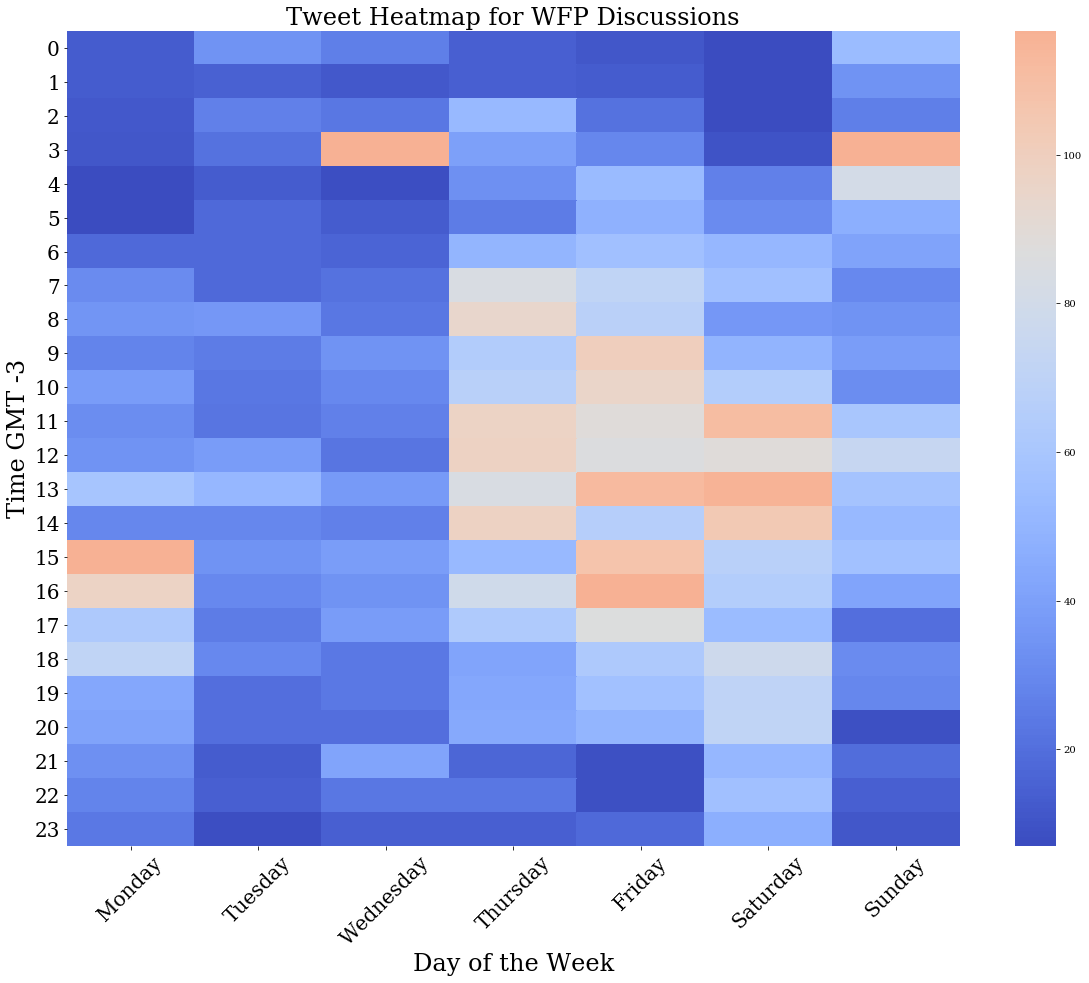

In [68]:
midpoint = (tweets_timeline.values.max() - tweets_timeline.values.min()) / 2

plt.figure(figsize=(20, 15))
plt.rcParams['font.family'] = "serif"
plt.title('Tweet Heatmap for WFP Discussions', fontsize=24)

ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='coolwarm',
                  robust=True,
                  center=midpoint,
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Day of the Week', fontsize=24)
plt.ylabel('Time GMT -3', fontsize=24)
ax.get_figure().savefig('heatmap_brasil.png')

In [69]:
user_count = pd.DataFrame()
user_count = user_flat['screen_name'].reset_index(name='Screen Name')
user_count = user_count.groupby('Screen Name')['index'].nunique()
top_25_names = user_count.nlargest(50).reset_index()

In [ ]:
bots = pd.DataFrame()
bots = df[df['screen_name'].str.contains('muerachavez|papaita|camburo', na=False)]
bots = bots['screen_name'].reset_index()
bots = bots.groupby('screen_name')['index'].nunique()
bots = bots.reset_index()

In [ ]:
bots_lst = bots['screen_name']
bots_2 = df.loc[df['screen_name'].isin(bots_lst)]
bots_2 = bots_2.groupby(['screen_name', 'hour'])['text'].count()

midpoint = (bots_2.values.max() - bots_2.values.min()) / 2
hour_of_day = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

plt.figure(figsize=(20, 20))
plt.rcParams['font.family'] = "serif"
plt.title('Apparent bots active around \"Venezuelanos refugiados\"', fontsize=24)

ax = (sns.heatmap(bots_2.unstack(),
                  cmap='coolwarm',
                  robust=True,
                 center=midpoint))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.xlabel('Hour of the Day UTC -3', fontsize=24)
plt.ylabel('Screen Name', fontsize=24)
ax.get_figure().savefig('heatmap_bots.png')

In [70]:
url = pd.DataFrame()
url = df['url'].reset_index()
url = url.groupby('url')['index'].nunique()
url_list = url.nlargest(50).reset_index()
url_list.to_csv('top50URLs.csv', sep='\t')

In [ ]:
bots_url = df.loc[df['screen_name'].isin(bots_lst)]
bots_url = bots_url.groupby(['domain', 'screen_name'])['text'].count().reset_index().sort_values('domain')

In [ ]:
bots_url.head(10)

In [ ]:
bots_url.groupby(['domain']).nunique()

In [71]:
df3 = df.groupby(df['created_at'].rename('Date')).size().reset_index(name='Number of Tweets')
df3 = df3.set_index(['Date'])
df3.index = pd.to_datetime(df3.index, unit='s')
df4 = df3.resample('H').sum().reset_index()

In [72]:
df_es3 = df_es.groupby(df['created_at'].rename('Date')).size().reset_index(name='Number of Tweets')
df_es3 = df_es3.set_index(['Date'])
df_es3.index = pd.to_datetime(df_es3.index, unit='s')
df_es4 = df_es3.resample('H').sum().reset_index()

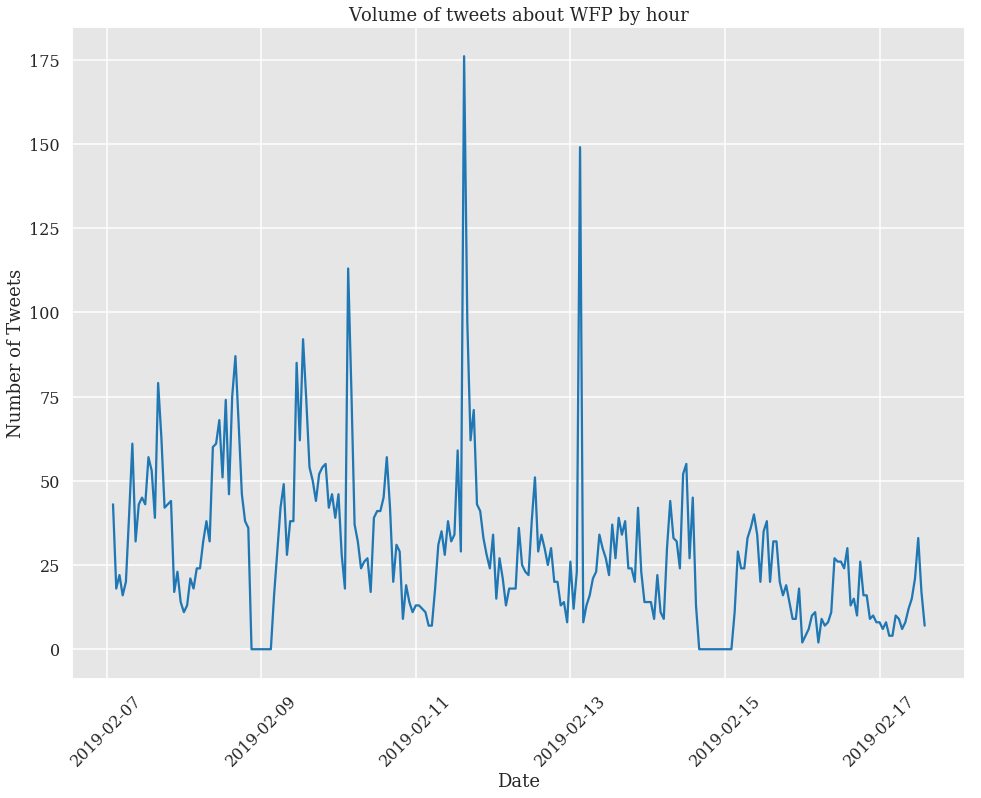

In [73]:
import matplotlib.dates as mdates
sns.set_context("talk")
sns.set_style("darkgrid", {'axes.facecolor':'.9'})
plt.figure(figsize=(16, 12))
plt.rcParams['font.family'] = "serif"
plt.xticks(rotation=45)
lp = sns.lineplot(data=df4, x="Date", y="Number of Tweets")
for label in (lp.get_xticklabels() + lp.get_yticklabels()):
    label.set_fontsize(16)
g1 = lp.set_title('Volume of tweets about WFP by hour').get_figure()
g1.savefig("Tweets_Hour.png")

## English

In [ ]:
parsed_urls_pt = pd.DataFrame()
parsed_urls_pt = df_ru['domain'].reset_index(name='url')
unique_pt = parsed_urls_pt.groupby('url')['index'].nunique()
unique_pt.nlargest(25)

In [ ]:
hashtag_data_pt = json_normalize(df_en['entities'], record_path='hashtags', meta=['user_mentions', 'urls'])
hashtags_pt = pd.DataFrame()
hashtags_pt = hashtag_data_pt['text'].reset_index(name='hashtags')
utags_pt = hashtags_pt.groupby('hashtags')['index'].nunique()
utags_pt.nlargest(50)

In [ ]:
user_count_pt = pd.DataFrame()
user_count_pt = df_en['screen_name'].reset_index(name='Screen Name')
user_count_pt = user_count_pt.groupby('Screen Name')['index'].nunique()
user_count_pt.nlargest(50)

In [ ]:
tweets_timeline_pt = df_en.groupby(by=['hour', 'day_of_week'])['text'].count()
midpoint = (tweets_timeline_pt.values.max() - tweets_timeline_pt.values.min()) / 2

plt.figure(figsize=(20, 15))
plt.rcParams['font.family'] = "serif"
plt.title('Tweet Heatmap for \"Venezuelanos refugiados\" discussions in Portuguese', fontsize=24)

ax = (sns.heatmap(tweets_timeline_pt.unstack(),
                  cmap='coolwarm',
                  robust=True,
                  center=midpoint,
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Day of the Week', fontsize=24)
plt.ylabel('Time GMT -3', fontsize=24)
ax.get_figure().savefig('heatmap_brasil_pt.png')

In [ ]:
#top_25_names_pt = user_count_pt.nlargest(50).reset_index()

In [ ]:
url_pt = pd.DataFrame()
url_pt = df_pt['url'].reset_index()
url_pt = url_pt.groupby('url')['index'].nunique()
url_list_pt = url_pt.nlargest(50).reset_index()
url_list.to_csv('top50URLs_pt.csv', sep='\t')

In [ ]:
#bots_url = df.loc[df['screen_name'].isin(bots_lst)]
#bots_url = bots_url.groupby(['domain', 'screen_name'])['text'].count().reset_index().sort_values('domain')

In [ ]:
df_pt3 = df_pt.groupby(df_pt['created_at'].rename('Date')).size().reset_index(name='Number of Tweets')
df_pt3 = df_pt3.set_index(['Date'])
df_pt3.index = pd.to_datetime(df_pt3.index, unit='s')
df_pt4 = df_pt3.resample('H').sum().reset_index()

In [ ]:
import matplotlib.dates as mdates
sns.set_context("talk")
sns.set_style("darkgrid", {'axes.facecolor':'.9'})
plt.figure(figsize=(16, 12))
plt.rcParams['font.family'] = "serif"
plt.xticks(rotation=45)
lp = sns.lineplot(data=df_pt4, x="Date", y="Number of Tweets")
#lp1 = (sns.lineplot(data=df_pt4, x="Date", y="Number of Tweets"), 
#     sns.lineplot(data=df_es4, x="Date", y="Number of Tweets"))
#plt.title('Volume of tweets about \"Venezuelanos refugiados\" by hour')
for label in (lp.get_xticklabels() + lp.get_yticklabels()):
    label.set_fontsize(16)
g1 = lp.set_title('Volume of Portuguese tweets about \"Venezuelanos refugiados\" by hour').get_figure()
g1.savefig("Tweets_Hour_PT.png")

## Newspaper

In [88]:
no_tweets = pd.DataFrame()
no_tweets = df[~df['domain'].str.contains('twitter.com', na=False)]
no_tweets = no_tweets[no_tweets['url'].str.contains("nan") == False]

In [94]:
url_no_tweets = pd.DataFrame()
url_no_tweets = no_tweets['url'].reset_index()
url_no_tweets = url_no_tweets.groupby('url')['index'].nunique()
url_no_list = url_no_tweets.nlargest(50).reset_index()
url_no_list.to_csv('top50URLs2.csv', sep='\t')

In [90]:
links = no_tweets['url']

#Intialize list articles_info list
articles_info = []
for i in links:
    #Intialize dictionary
    article_dict = {}
    #Insert link "i" into the dictionary
    article_dict["link"] = i
    #Pass link into Article() function
    art = Article(i)
    #Download contents of art object
    art.download()
    
    #Try/except is included because not all articles can be parsed
    try:
        #If article can be successfully parsed then insert its text, title, publish_date, keywords
        #and summary into corresponding keys
        art.parse()
        article_dict["text"] = art.text
        article_dict["title"] = art.title
        article_dict["date"] = art.publish_date
        article_dict["date"] = art.publish_date
        art.nlp()
        article_dict["keywords"] = art.keywords
        article_dict["summary"] = art.summary
    except: 
        pass
        
    #Insert dictionary of article info into the articles_info list
    articles_info.append(article_dict)
#Pass the list of dictionaries into a pandas data frame
corpus = pd.DataFrame(articles_info)

In [102]:
palantir = pd.DataFrame()
palantir = df[df['text'].str.contains('palantir', na=True)].reset_index()